# Speech + Phonetic AAI Model

In [160]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from os.path import join
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks
from time import time
from datetime import datetime
import shutil 
import argparse
from functools import partial
import pickle
from IPython.display import Audio

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Reshape, GRU, InputLayer, AlphaDropout, Activation, BatchNormalization, Dropout, Flatten, Dense, Bidirectional, LSTM, Conv1D, SpatialDropout1D, Concatenate

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

In [127]:
np_load_old = partial(np.load)
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

## Metric Function

In [128]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def R2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred), axis = 0) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true, axis = 0)), axis = 0) 
    return K.mean(1 - (SS_res/SS_tot), axis=0)

## Utility Functions

In [129]:
#Function for preprocessing data
def delete_params(params):
    '''
    This function remove JX, WC, TRX, TRY, and MS1,2,3 paramter
    '''
    DEL_PARAMS_LIST = [2,8,15,16,21,22,23]
    return np.delete(params,DEL_PARAMS_LIST , axis=1)

In [130]:
def compute_rmse(actual,pred, axis=1):
    # Compute RMSE by row (axis=1) result in rmse of each data
    # Compute RMSE by column (axis=0) result in rmse of each label
    return np.sqrt((np.square(actual - pred)).mean(axis=axis))

In [131]:
def evaluate_model(y_pred, label):
    y_pred = enc.inverse_transform(y_pred)
    label = enc.inverse_transform(label)
    print('Confusion Matrix')
    print(confusion_matrix(label, y_pred))
    print('Classification Report')
    print(classification_report(label, y_pred))

In [132]:
def compute_se(actual,pred):
    return np.sqrt((np.square(actual - pred)))

## Load Data 

In [133]:
def prep_data():

    # load data from preprocess pipeline
    dataset = np.load(join('../data/d_dataset_p1/prep_data_13_2','training_subsets.npz'))
    X_train =dataset['X_train']
    y_train= dataset['y_train']
    z_train= dataset['z_train']
    X_val = dataset['X_val']
    y_val = dataset['y_val']
    z_val = dataset['z_val']
    X_test = dataset['X_test']
    y_test = dataset['y_test']
    z_test = dataset['z_test']
    a_test = dataset['audio_test']
    a_val = dataset['audio_val']
    
    y_train = delete_params(y_train)
    y_val = delete_params(y_val)
    y_test = delete_params(y_test)

    print('Train features and labels %s %s'%(str(X_train.shape),str(y_train.shape)))
    print('Validating features and labels %s %s'%(str(X_val.shape),str(y_val.shape)))
    print('Test features and labels %s %s'%(str(X_test.shape),str(y_test.shape)))

    return X_train, X_val, X_test, y_train, y_val, y_test, z_train, z_val, z_test, a_test, a_val

In [134]:
X_train, X_val, X_test, y_train, y_val, y_test, z_train, z_val, z_test, a_test, a_val = prep_data()

Train features and labels (98746, 24, 39) (98746, 17)
Validating features and labels (12094, 24, 39) (12094, 17)
Test features and labels (12092, 24, 39) (12092, 17)


In [135]:
print(set(z_test))

{'A', 'O', '@', '2', 'V', 'E', 'y', 'Q', 'M', 'i', '9', 'o', '7', 'U', 'e', 'a', '&', 'E:', 'u'}


In [136]:
print('Train features and labels {} {} {}'.format(str(X_train.shape),str(y_train.shape),str(z_train.shape)))
print('Validating features and labels {} {} {}'.format(str(X_val.shape),str(y_val.shape),str(z_val.shape)))
print('Test features and labels {} {} {}'.format(str(X_test.shape),str(y_test.shape),str(z_test.shape)))

Train features and labels (98746, 24, 39) (98746, 17) (98746,)
Validating features and labels (12094, 24, 39) (12094, 17) (12094,)
Test features and labels (12092, 24, 39) (12092, 17) (12092,)


### One-hot label 

In [137]:
z_train_oe=z_train.reshape(-1,1)
z_val_oe=z_val.reshape(-1,1)
z_test_oe=z_test.reshape(-1,1)

In [138]:
enc = OneHotEncoder(handle_unknown = 'ignore')
enc.fit(z_train_oe)

z_train_oe = enc.transform(z_train_oe).toarray()
z_test_oe = enc.transform(z_test_oe).toarray()
z_val_oe = enc.transform(z_val_oe).toarray()

In [139]:
z_train_oe.shape

(98746, 19)

In [140]:
z_val_oe.shape

(12094, 19)

In [141]:
z_train_oe[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0.])

## Defined Model 

In [12]:
N_OUTPUTS = 17

pLSTM = partial(LSTM,
    kernel_initializer='he_uniform',
    return_sequences=True)

pDense = partial(Dense,
    kernel_initializer='he_normal',
    activation='elu')

def init_bilstm(unit=128, bi_layer_num=3, drop_rate=0.2):

    def bilstm(input_shape_1,input_shape_2):
        
        input_x = keras.Input(shape=(input_shape_1,input_shape_2))
        # feature extraction layers
        x = input_x
        for i in range(bi_layer_num-1):
            x = Bidirectional(pLSTM(unit))(x)
            if drop_rate: 
                x = SpatialDropout1D(rate=drop_rate)(x)
        # output layers
        x = Bidirectional(pLSTM(unit*2, return_sequences=False))(x)
        if drop_rate: 
            x = Dropout(rate=drop_rate)(x)
        x = pDense(1024, activation='relu')(x)
        outputs_param = pDense(N_OUTPUTS, activation='linear')(x)
        
        model = keras.Model(inputs=input_x, outputs=outputs_param)
        # model.summary()
        return model
    return bilstm

In [13]:
model = init_bilstm()(24, 39)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 39)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 24, 256)           172032    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 24, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 24, 256)           394240    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 24, 256)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               1050624   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0     

## Compile Model 

In [16]:
model.compile(optimizer='adam',loss='mse',metrics=[rmse, R2])

## Train Model 

In [17]:
PATIENCE = 10
BATCH_SIZE = 128
EPOCHS = 30

In [18]:
early = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=PATIENCE, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callback_list = [early]

In [19]:
history = model.fit(X_train,y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val,y_val),
    callbacks=callback_list)

Train on 98746 samples, validate on 12094 samples
Epoch 1/30
98746/98746 [==============================] - 36s 368us/sample - loss: 0.0734 - rmse: 0.2469 - R2: 0.6812 - val_loss: 0.0404 - val_rmse: 0.1809 - val_R2: 0.8270
Epoch 2/30
98746/98746 [==============================] - 21s 216us/sample - loss: 0.0477 - rmse: 0.1954 - R2: 0.7945 - val_loss: 0.0362 - val_rmse: 0.1705 - val_R2: 0.8449
Epoch 3/30
98746/98746 [==============================] - 21s 215us/sample - loss: 0.0415 - rmse: 0.1815 - R2: 0.8215 - val_loss: 0.0343 - val_rmse: 0.1622 - val_R2: 0.8542
Epoch 4/30
98746/98746 [==============================] - 21s 214us/sample - loss: 0.0377 - rmse: 0.1729 - R2: 0.8375 - val_loss: 0.0349 - val_rmse: 0.1619 - val_R2: 0.8497
Epoch 5/30
98746/98746 [==============================] - 21s 215us/sample - loss: 0.0350 - rmse: 0.1669 - R2: 0.8489 - val_loss: 0.0347 - val_rmse: 0.1608 - val_R2: 0.8521
Epoch 6/30
98746/98746 [==============================] - 21s 214us/sample - loss: 0.

In [20]:
model.save('model_baseline.hdf5')

## Evaluation 

In [21]:
model.evaluate(X_test,y_test,verbose=0)

[0.032602244376239105, 0.14959863, 0.8500039]

In [22]:
y_pred = model.predict(X_test)

In [24]:
err = compute_rmse(y_test,y_pred, axis=0)

In [25]:
print(err)

[0.15738225 0.13672984 0.14865203 0.19487172 0.16036555 0.21226606
 0.25415587 0.10173931 0.1306819  0.24195167 0.13813107 0.1652471
 0.17270515 0.26993943 0.18364394 0.15410301 0.15102673]


## Defined Model + Phonetic

In [26]:
N_OUTPUTS = 17

pLSTM = partial(LSTM,
    kernel_initializer='he_uniform',
    return_sequences=True)

pDense = partial(Dense,
    kernel_initializer='he_normal',
    activation='elu')

def init_bilstm_pho(unit=128, bi_layer_num=3, drop_rate=0.2):

    def bilstm(input_shape_1,input_shape_2):
        
        input_x = keras.Input(shape=(input_shape_1,input_shape_2))
        # feature extraction layers
        x = input_x
        z = input_x
        for i in range(bi_layer_num-1):
            x = Bidirectional(pLSTM(unit))(x)
            if drop_rate: 
                x = SpatialDropout1D(rate=drop_rate)(x)
        # output layers
        x = Bidirectional(pLSTM(unit*2, return_sequences=False))(x)
        if drop_rate: 
            x = Dropout(rate=drop_rate)(x)
                
        for i in range(bi_layer_num-2):
            z = Bidirectional(pLSTM(unit))(z)
            if drop_rate: 
                z = SpatialDropout1D(rate=drop_rate)(z)
        z = Bidirectional(pLSTM(unit*2, return_sequences=False))(z)
        if drop_rate: 
            z = Dropout(rate=drop_rate)(z)
        z = pDense(100, activation='relu')(z)
        outputs_pho = pDense(19, activation='softmax', name='pho')(x)
        
        x = Concatenate()([x,z])
        x = pDense(512, activation='relu')(x)
        outputs_param = pDense(N_OUTPUTS, activation='linear', name='param')(x)
        
        model = keras.Model(inputs=input_x, outputs=[outputs_param, outputs_pho])
        # model.summary()
        return model
    return bilstm

In [27]:
model_pho = init_bilstm_pho()(24, 39)

In [28]:
model_pho.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 24, 39)]     0                                            
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 24, 256)      172032      input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 24, 256)      0           bidirectional_3[0][0]            
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None, 24, 256)      172032      input_2[0][0]                    
____________________________________________________________________________________________

In [29]:
losses = {
    "param": "mse",
    "pho": tf.keras.losses.CategoricalCrossentropy(from_logits=True),
}
lossWeights = {"param": 1.0, "pho": 1.0}

In [30]:
metrics = {
    "param": [rmse, R2],
    "pho": "accuracy",
}

## Compile Model 

In [31]:
model_pho.compile(optimizer='adam',loss=losses, loss_weights=lossWeights, metrics=metrics)

## Train Model 

In [32]:
PATIENCE = 10
BATCH_SIZE = 128
EPOCHS = 30

In [33]:
early = callbacks.EarlyStopping(monitor='param_loss', min_delta=0, patience=PATIENCE, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callback_list = [early]

In [34]:
history = model_pho.fit(X_train,{"param": y_train, "pho": z_train_oe},
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=2,
    validation_data=(X_val,{"param": y_val, "pho": z_val_oe}),
    callbacks=callback_list)

Train on 98746 samples, validate on 12094 samples
Epoch 1/30
98746/98746 - 54s - loss: 2.3965 - param_loss: 0.0713 - pho_loss: 2.3251 - param_rmse: 0.2419 - param_R2: 0.6899 - pho_accuracy: 0.7161 - val_loss: 2.2395 - val_param_loss: 0.0432 - val_pho_loss: 2.1963 - val_param_rmse: 0.1845 - val_param_R2: 0.8155 - val_pho_accuracy: 0.8358
Epoch 2/30
98746/98746 - 32s - loss: 2.2864 - param_loss: 0.0470 - pho_loss: 2.2394 - param_rmse: 0.1938 - param_R2: 0.7974 - pho_accuracy: 0.7928 - val_loss: 2.2200 - val_param_loss: 0.0391 - val_pho_loss: 2.1806 - val_param_rmse: 0.1743 - val_param_R2: 0.8325 - val_pho_accuracy: 0.8508
Epoch 3/30
98746/98746 - 32s - loss: 2.2617 - param_loss: 0.0411 - pho_loss: 2.2205 - param_rmse: 0.1814 - param_R2: 0.8224 - pho_accuracy: 0.8113 - val_loss: 2.2225 - val_param_loss: 0.0378 - val_pho_loss: 2.1845 - val_param_rmse: 0.1686 - val_param_R2: 0.8387 - val_pho_accuracy: 0.8463
Epoch 4/30
98746/98746 - 32s - loss: 2.2534 - param_loss: 0.0379 - pho_loss: 2.2155

In [35]:
model_pho.save('model_baseline_pho.hdf5')

## Evaluation

In [39]:
y_pred, y_pho_pred = model_pho.predict(X_test)

In [40]:
err = compute_rmse(y_test,y_pred, axis=0)
print(err)

[0.16499175 0.13846306 0.15626041 0.20971853 0.16883098 0.22409996
 0.26204728 0.10337965 0.13968868 0.25097486 0.14635381 0.16778201
 0.18071192 0.27521861 0.18504289 0.15457323 0.15504013]


In [45]:
evaluate_model(y_pho_pred, z_test_oe)

Confusion Matrix
[[608   0   1  15   0   0   0   0   0   6  13   1   5  37   0   0   0   0
    0]
 [  0 668   0   1   0   0   0   0   2   0   0   1   0   0   0   0   0   2
   13]
 [  6   1 365   4   0   3   0   0   5  80   8  14  67  11   0   0   2   0
    0]
 [ 14   0   0 622   0   0   2   0   6   0   5   6   4   0   0   0   0   0
    0]
 [  1   0   0  12 595   0  31   1   0   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0 550   0   0   0   0  13   0  19  20   0   0   0   0
    0]
 [  0   0   0   1  12   0 614  36   0   0   1   0   0   1   0   0   0   0
    0]
 [  0   0   0   0   0   1  17 600   0   0   0   0   0   0   7   0   0   0
    0]
 [  0   1  18   4   0   0   0   0 598   0   0  29   0   0   0   0   0   0
    0]
 [  5   0  18   2   0   1   0   0   3 562   7  11  47   1   0   0   8   0
    0]
 [ 16   0   1   3   0  44   2   0   0   1 546   0  10  10   0   0   0   0
    0]
 [  5   1  16   0   0   0   0   0  54   5   0 537   0   0   0   0   5  24
    0]
 [  1   1  

## Embedded Model 

In [15]:
N_OUTPUTS = 17

pLSTM = partial(LSTM,
    kernel_initializer='he_uniform',
    return_sequences=True)

pDense = partial(Dense,
    kernel_initializer='he_normal',
    activation='elu')

def init_embeded_pho(unit=128, drop_rate=0.2):
    
    def embeded(input_shape_1,input_shape_2):
        inputs = keras.Input(shape=(input_shape_1,input_shape_2))
        x = pLSTM(100)(inputs)
        x = Flatten()(x)
        outputs = pDense(19, activation='softmax')(x)
        return keras.Model(inputs=inputs, outputs=outputs)
    return embeded

In [16]:
embedded = init_embeded_pho()(24, 39)
embedded.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 39)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 24, 100)           56000     
_________________________________________________________________
flatten (Flatten)            (None, 2400)              0         
_________________________________________________________________
dense (Dense)                (None, 19)                45619     
Total params: 101,619
Trainable params: 101,619
Non-trainable params: 0
_________________________________________________________________


## Compile Model 

In [17]:
embedded.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

## Train Model 

In [18]:
PATIENCE = 10
BATCH_SIZE = 128
EPOCHS = 40

In [19]:
early = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=PATIENCE, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callback_list = [early]

In [20]:
history = embedded.fit(X_train,z_train_oe,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=2,
    validation_data=(X_val,z_val_oe),
    callbacks=callback_list)

Train on 98746 samples, validate on 12094 samples
Epoch 1/40
98746/98746 - 9s - loss: 2.3028 - accuracy: 0.7467 - val_loss: 2.1871 - val_accuracy: 0.8489
Epoch 2/40
98746/98746 - 4s - loss: 2.2026 - accuracy: 0.8357 - val_loss: 2.1597 - val_accuracy: 0.8771
Epoch 3/40
98746/98746 - 4s - loss: 2.1749 - accuracy: 0.8615 - val_loss: 2.1528 - val_accuracy: 0.8809
Epoch 4/40
98746/98746 - 4s - loss: 2.1597 - accuracy: 0.8762 - val_loss: 2.1466 - val_accuracy: 0.8883
Epoch 5/40
98746/98746 - 4s - loss: 2.1488 - accuracy: 0.8864 - val_loss: 2.1504 - val_accuracy: 0.8827
Epoch 6/40
98746/98746 - 4s - loss: 2.1401 - accuracy: 0.8951 - val_loss: 2.1470 - val_accuracy: 0.8852
Epoch 7/40
98746/98746 - 4s - loss: 2.1343 - accuracy: 0.9003 - val_loss: 2.1399 - val_accuracy: 0.8931
Epoch 8/40
98746/98746 - 4s - loss: 2.1283 - accuracy: 0.9061 - val_loss: 2.1421 - val_accuracy: 0.8904
Epoch 9/40
98746/98746 - 4s - loss: 2.1235 - accuracy: 0.9103 - val_loss: 2.1462 - val_accuracy: 0.8859
Epoch 10/40
98

In [21]:
embedded.save('embedded.hdf5')

In [22]:
y_pred = embedded.predict(X_test)
evaluate_model(y_pred, z_test_oe)

Confusion Matrix
[[604   0   1  29   0   0   0   0   0  10  16   0  11  15   0   0   0   0
    0]
 [  0 658   2   3   0   0   0   0   0   0   1   0   0   0   0   0   0   5
   18]
 [  2   1 338   2   0   4   0   0   4  83   3  15 104   2   0   0   7   1
    0]
 [  6   1   0 641   0   0   2   0   5   0   0   0   3   1   0   0   0   0
    0]
 [  2   0   0   3 583   0  46   5   0   0   0   0   0   0   0   1   0   0
    0]
 [  0   0   0   0   0 564   0   0   0   1  14   0  17   6   0   0   0   0
    0]
 [  0   0   0   6   7   0 620  27   1   0   1   0   0   3   0   0   0   0
    0]
 [  0   0   0   1   0   1  24 595   0   0   0   0   0   0   4   0   0   0
    0]
 [  0   5  12   4   0   0   0   0 601   1   0  22   0   0   0   0   0   5
    0]
 [  3   0   8   2   0   0   0   0   0 600   4  11  29   0   0   0   8   0
    0]
 [ 11   0   0   5   0  33   4   0   0   6 554   0  15   4   0   0   0   0
    1]
 [  0   1   8   0   0   0   0   0  50  10   1 514   3   0   0   0   3  56
    1]
 [  2   0  

In [23]:
embedded = tf.keras.models.load_model('embedded.hdf5')

In [24]:
model = tf.keras.Sequential()
for layer in embedded.layers[:-1]:
    model.add(layer)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 100)           56000     
_________________________________________________________________
flatten (Flatten)            (None, 2400)              0         
Total params: 56,000
Trainable params: 56,000
Non-trainable params: 0
_________________________________________________________________


In [25]:
y_pred = model.predict(X_test)

In [26]:
y_pred.shape

(12092, 2400)

## Test Embedding

In [117]:
from scipy.spatial.distance import cosine

In [118]:
print([(idx, item) for idx, item in enumerate(z_test.tolist()[:30])])

[(0, 'O'), (1, '2'), (2, 'U'), (3, 'o'), (4, '@'), (5, '9'), (6, 'u'), (7, 'E'), (8, '2'), (9, '2'), (10, 'A'), (11, '@'), (12, 'y'), (13, 'i'), (14, 'E'), (15, 'Q'), (16, 'u'), (17, 'o'), (18, '7'), (19, 'E:'), (20, '9'), (21, 'E:'), (22, '&'), (23, 'V'), (24, 'E:'), (25, 'o'), (26, '7'), (27, 'a'), (28, '2'), (29, 'i')]


In [129]:
def cosine_sim(idx, idx2):
    sim = 1 - cosine(y_pred[idx], y_pred[idx2])
    if sim > 0.40:
        print('{} {}: {}'.format(z_test[idx], z_test[idx2],sim))

In [130]:
for i in range(30):
    for j in range(30):
        cosine_sim(i, j)

O O: 1.0
2 2: 1.0
2 2: 0.5821772217750549
U U: 1.0
o o: 1.0
@ @: 1.0
9 9: 1.0
9 9: 0.6471675634384155
u u: 1.0
E E: 1.0
E E: 0.6792986392974854
2 2: 0.5821772217750549
2 2: 1.0
2 2: 1.0
A A: 1.0
@ @: 1.0
y y: 1.0
i i: 1.0
i E:: 0.43088242411613464
i i: 0.4158954620361328
E E: 0.6792986392974854
E E: 1.0
Q Q: 1.0
u u: 1.0
o o: 1.0
7 7: 1.0
7 7: 0.4666718542575836
E: E:: 1.0
E: E:: 0.4112861156463623
E: E:: 0.5355876088142395
9 9: 0.6471675634384155
9 9: 1.0
E: E:: 0.4112861156463623
E: E:: 1.0
E: E:: 0.4070873558521271
& &: 1.0
V V: 1.0
E: i: 0.43088242411613464
E: E:: 0.5355876088142395
E: E:: 0.4070873558521271
E: E:: 1.0
o o: 1.0
7 7: 0.4666718542575836
7 7: 1.0
a a: 1.0
2 2: 1.0
i i: 0.4158954620361328
i i: 1.0


# Model with Embedding 

## Baseline 

In [23]:
N_OUTPUTS = 17

pLSTM = partial(LSTM,
    kernel_initializer='he_uniform',
    return_sequences=True)

pDense = partial(Dense,
    kernel_initializer='he_normal',
    activation='elu')

def init_bilstm(unit=128, bi_layer_num=3, drop_rate=0.2):

    def bilstm(input_shape_1,input_shape_2):
        
        input_x = keras.Input(shape=(input_shape_1,input_shape_2))
        # feature extraction layers
        x = input_x
        for i in range(bi_layer_num-1):
            x = Bidirectional(pLSTM(unit))(x)
            if drop_rate: 
                x = SpatialDropout1D(rate=drop_rate)(x)
        # output layers
        x = Bidirectional(pLSTM(unit, return_sequences=False))(x)
        if drop_rate: 
            x = Dropout(rate=drop_rate)(x)
        outputs_param = pDense(N_OUTPUTS, activation='linear')(x)
        
        model = keras.Model(inputs=input_x, outputs=outputs_param)
        # model.summary()
        return model
    return bilstm

In [28]:
model = init_bilstm()(24, 39)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 24, 39)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 24, 256)           172032    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 24, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 24, 256)           394240    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 24, 256)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0   

## Compile Model 

In [29]:
model.compile(optimizer='adam',loss='mse',metrics=[rmse, R2])

## Train Model 

In [30]:
PATIENCE = 10
BATCH_SIZE = 128
EPOCHS = 30

In [31]:
early = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=PATIENCE, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callback_list = [early]

In [32]:
history = model.fit(X_train,y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val,y_val),
    callbacks=callback_list)

Train on 98746 samples, validate on 12094 samples
Epoch 1/30
98746/98746 [==============================] - 29s 291us/sample - loss: 0.0784 - rmse: 0.2571 - R2: 0.6587 - val_loss: 0.0436 - val_rmse: 0.1841 - val_R2: 0.8149
Epoch 2/30
98746/98746 [==============================] - 16s 163us/sample - loss: 0.0498 - rmse: 0.2014 - R2: 0.7853 - val_loss: 0.0382 - val_rmse: 0.1709 - val_R2: 0.8370
Epoch 3/30
98746/98746 [==============================] - 16s 164us/sample - loss: 0.0434 - rmse: 0.1873 - R2: 0.8127 - val_loss: 0.0349 - val_rmse: 0.1629 - val_R2: 0.8511
Epoch 4/30
98746/98746 [==============================] - 16s 164us/sample - loss: 0.0398 - rmse: 0.1794 - R2: 0.8281 - val_loss: 0.0375 - val_rmse: 0.1656 - val_R2: 0.8401
Epoch 5/30
98746/98746 [==============================] - 16s 164us/sample - loss: 0.0374 - rmse: 0.1739 - R2: 0.8385 - val_loss: 0.0403 - val_rmse: 0.1689 - val_R2: 0.8309
Epoch 6/30
98746/98746 [==============================] - 16s 164us/sample - loss: 0.

In [33]:
model.save('model_baseline_2.hdf5')

## Evaluation 

In [34]:
model.evaluate(X_test,y_test,verbose=0)

[0.03239709647693383, 0.1489216, 0.8514758]

In [35]:
y_pred = model.predict(X_test)

In [36]:
err = compute_rmse(y_test,y_pred, axis=0)

In [37]:
print(err)

[0.1568435  0.1333071  0.14723637 0.20025707 0.16252713 0.21058316
 0.25390446 0.09769458 0.13031462 0.24590375 0.13846071 0.16655805
 0.16988616 0.26658766 0.17800331 0.15121139 0.15160024]


## Embedded input model

In [24]:
N_OUTPUTS = 17

pLSTM = partial(LSTM,
    kernel_initializer='he_uniform',
    return_sequences=True)

pDense = partial(Dense,
    kernel_initializer='he_normal',
    activation='elu')

embedded = tf.keras.models.load_model('embedded.hdf5')

embedded_layers = tf.keras.Sequential()
for layer in embedded.layers[:-2]:
    layer.trainable = False
    embedded_layers.add(layer)
embedded_layers.summary()

def init_embeded_bilstm(unit=128, bi_layer_num=3, drop_rate=0.2):

    def bilstm(input_shape_1,input_shape_2):
        
        input_x = keras.Input(shape=(input_shape_1,input_shape_2))
        
        emb = embedded_layers(input_x)
        
        # feature extraction layers
        x = Concatenate()([input_x,emb])
        for i in range(bi_layer_num-1):
            x = Bidirectional(pLSTM(unit))(x)
            if drop_rate: 
                x = SpatialDropout1D(rate=drop_rate)(x)
        # output layers
        x = Bidirectional(pLSTM(unit, return_sequences=False))(x)
        if drop_rate: 
            x = Dropout(rate=drop_rate)(x)
        outputs_param = pDense(N_OUTPUTS, activation='linear')(x)
        
        model = keras.Model(inputs=input_x, outputs=outputs_param)
        # model.summary()
        return model
    return bilstm

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 100)           56000     
Total params: 56,000
Trainable params: 0
Non-trainable params: 56,000
_________________________________________________________________


In [25]:
emb_model = init_embeded_bilstm()(24, 39)
emb_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 24, 39)]     0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 24, 100)      56000       input_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 24, 139)      0           input_2[0][0]                    
                                                                 sequential[1][0]                 
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 24, 256)      274432      concatenate[0][0]          

## Compile Model 

In [26]:
emb_model.compile(optimizer='adam',loss='mse',metrics=[rmse, R2])

## Train Model 

In [27]:
PATIENCE = 10
BATCH_SIZE = 128
EPOCHS = 30

In [28]:
early = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=PATIENCE, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callback_list = [early]

In [29]:
history = emb_model.fit(X_train,y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=2,
    validation_data=(X_val,y_val),
    callbacks=callback_list)

Train on 98746 samples, validate on 12094 samples
Epoch 1/30
98746/98746 - 44s - loss: 0.0594 - rmse: 0.2215 - R2: 0.7398 - val_loss: 0.0375 - val_rmse: 0.1684 - val_R2: 0.8401
Epoch 2/30
98746/98746 - 25s - loss: 0.0378 - rmse: 0.1764 - R2: 0.8370 - val_loss: 0.0364 - val_rmse: 0.1630 - val_R2: 0.8447
Epoch 3/30
98746/98746 - 23s - loss: 0.0343 - rmse: 0.1676 - R2: 0.8520 - val_loss: 0.0367 - val_rmse: 0.1620 - val_R2: 0.8441
Epoch 4/30
98746/98746 - 24s - loss: 0.0325 - rmse: 0.1628 - R2: 0.8598 - val_loss: 0.0358 - val_rmse: 0.1603 - val_R2: 0.8471
Epoch 5/30
98746/98746 - 25s - loss: 0.0307 - rmse: 0.1587 - R2: 0.8672 - val_loss: 0.0365 - val_rmse: 0.1606 - val_R2: 0.8452
Epoch 6/30
98746/98746 - 25s - loss: 0.0296 - rmse: 0.1559 - R2: 0.8721 - val_loss: 0.0356 - val_rmse: 0.1583 - val_R2: 0.8483
Epoch 7/30
98746/98746 - 25s - loss: 0.0284 - rmse: 0.1532 - R2: 0.8766 - val_loss: 0.0345 - val_rmse: 0.1562 - val_R2: 0.8522
Epoch 8/30
98746/98746 - 24s - loss: 0.0275 - rmse: 0.1509 - 

In [30]:
emb_model.save('model_embedded_bilstm.hdf5')

## Evaluation 

In [17]:
emb_model = tf.keras.models.load_model('model_embedded_bilstm.hdf5', custom_objects={'rmse': rmse, 'R2':R2})

In [55]:
emb_model.evaluate(X_test,y_test,verbose=0)

[0.03327701454338276, 0.14917862, 0.8477405]

In [142]:
y_pred = emb_model.predict(X_test)

### Check error by each data 

In [143]:
errs = compute_rmse(y_test,y_pred, axis=1)

In [144]:
print(err)

[0.11166411 0.06921014 0.08983744 ... 0.08429862 0.04483162 0.11878191]


### Error rank by highest 

In [145]:
err_df = pd.DataFrame({'phonetic':z_test, 'err':errs})

In [146]:
err_df.head()

,phonetic,err
0,2,0.121431
1,2,0.067091
2,O,0.089768
3,i,0.092908
4,Q,0.161480


In [147]:
err_df.sort_values('err')

,phonetic,err
1120,O,0.034730
6010,A,0.034919
6532,a,0.035045
2753,y,0.036230
528,E:,0.036260
...,...,...
5324,&,0.727914
187,V,0.728262
311,&,0.744372
7173,&,0.765260


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000272CD5FA588>]],
      dtype=object)

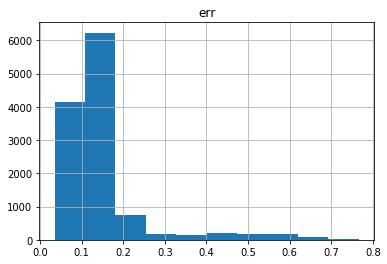

In [148]:
err_df.hist('err')

In [149]:
err_df_high = err_df[err_df['err'] > 0.15]

In [150]:
err_df_high.head()

,phonetic,err
4,Q,0.161480
5,&,0.182963
10,e,0.193200
15,&,0.151449
19,2,0.162316


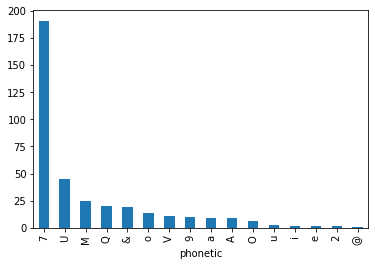

In [151]:
err_df[err_df['err'] > 0.5].groupby('phonetic')['phonetic'].count().sort_values(ascending=False).plot.bar()

In [152]:
err_df_high.groupby('phonetic')['phonetic'].count()

phonetic
&     152
2     114
7     312
9     186
@     129
A     126
E     193
E:    127
M     235
O     164
Q     216
U     180
V     212
a     160
e     176
i     226
o     145
u     148
y     148
Name: phonetic, dtype: int64

## Evaluate each param of each row

In [153]:
se = compute_se(y_test,y_pred)
errs = compute_rmse(y_test,y_pred, axis=1)

In [154]:
df_se = pd.DataFrame(se, columns=["HX","HY","JA","LP","LD","VS","VO","TCX","TCY","TTX","TTY","TBX","TBY","TS1","TS2","TS3","TS4"])

In [155]:
df_se['phonetic'] = z_test
df_se['mean_err'] = errs
df_se['audio'] = a_test

In [156]:
df_se.head()

,HX,HY,JA,LP,LD,VS,VO,TCX,TCY,TTX,TTY,TBX,TBY,TS1,TS2,TS3,TS4,phonetic,mean_err,audio
0,0.022174,0.061488,0.019927,0.018761,0.006598,0.300054,0.295900,0.000850,0.102922,0.006510,0.010075,0.000918,0.130769,0.176245,0.039091,0.086492,0.010521,2,0.121431,"[0.03047676, 0.02607328, 0.02177687, 0.0147435..."
1,0.147639,0.012120,0.018323,0.005361,0.019185,0.081494,0.058105,0.027587,0.105365,0.021292,0.046956,0.053635,0.091418,0.124690,0.006603,0.041476,0.027556,2,0.067091,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0.055975,0.045816,0.154573,0.073162,0.065121,0.067778,0.190482,0.001135,0.066062,0.036586,0.092204,0.065032,0.049728,0.175899,0.003359,0.018951,0.071955,O,0.089768,"[0.016970541, 0.026040426, 0.33393437, 0.07212..."
3,0.078314,0.069676,0.001433,0.236791,0.194301,0.067175,0.033828,0.007061,0.009583,0.070383,0.059727,0.034163,0.006280,0.037509,0.151717,0.015675,0.041629,i,0.092908,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0.058790,0.096246,0.006789,0.003208,0.201357,0.055927,0.065633,0.056336,0.011343,0.114255,0.524291,0.090268,0.202745,0.154637,0.028841,0.066194,0.113653,Q,0.161480,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


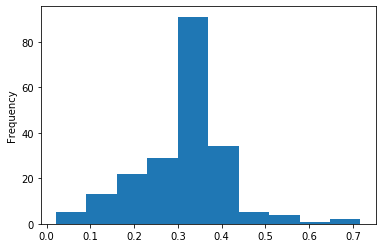

In [121]:
df_se[(df_se['phonetic'] == '7') & (df_se['mean_err'] > 0.5)]['TS4'].plot.hist()

## EDA audio of testing data 

In [173]:
df_se_sort = df_se.sort_values('mean_err',ascending=False)
df_se_sort.reset_index(drop=True, inplace=True)

In [215]:
df_se_sort[df_se_sort['phonetic'] == '&'].head(n=5)

,HX,HY,JA,LP,LD,VS,VO,TCX,TCY,TTX,TTY,TBX,TBY,TS1,TS2,TS3,TS4,phonetic,mean_err,audio
0,0.664692,0.441207,0.322623,0.482189,0.810838,1.281890,1.119328,0.153846,0.783302,0.249519,0.140264,1.020483,0.503561,1.250012,0.811591,0.935526,0.591536,&,0.766471,"[0.006525553, 0.01001169, 0.1284806, 0.0277639..."
1,0.793946,0.019759,0.414293,0.458114,0.995455,0.787040,1.279365,0.025928,0.771578,0.579290,0.119644,0.754042,0.600746,1.467994,0.869459,0.706246,0.641149,&,0.765260,"[0.0012514566, -0.00038389416, -0.001600003, -..."
2,0.696698,0.196412,0.338644,0.345511,0.918705,1.266298,1.491339,0.055294,0.521751,0.360764,0.286188,0.680752,0.398347,1.177321,0.941843,0.588952,0.510309,&,0.744372,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0.587403,0.016597,0.316835,0.601370,1.034259,0.984241,1.260394,0.061953,0.539019,0.318522,0.045738,0.611658,0.614369,1.439379,0.726755,0.656136,0.627074,&,0.727914,"[0.005676958, 0.015730796, 0.011855525, -0.002..."
6,0.407856,0.185749,0.300075,0.458909,0.898188,1.172327,1.346107,0.063154,0.608451,0.369349,0.197767,0.722983,0.400103,1.244811,0.922416,0.710490,0.425595,&,0.720026,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [216]:
Audio(df_se_sort['audio'][0], rate=16000)

In [217]:
df_se_sort[df_se_sort['phonetic'] == '&'].tail(n=5)

,HX,HY,JA,LP,LD,VS,VO,TCX,TCY,TTX,TTY,TBX,TBY,TS1,TS2,TS3,TS4,phonetic,mean_err,audio
12073,0.046639,0.069662,0.001109,0.040464,0.004909,0.011730,0.003624,0.012097,0.064916,0.016601,0.003051,0.056303,0.001542,0.025911,0.061337,0.082857,0.032844,&,0.041328,"[0.07384272, -0.08132631, 0.3420766, 0.5936177..."
12077,0.037757,0.057475,0.046583,0.036482,0.013505,0.013068,0.003729,0.009773,0.005531,0.012906,0.041517,0.082495,0.039344,0.060018,0.054379,0.038632,0.021412,&,0.040203,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12079,0.000552,0.022493,0.066073,0.007805,0.003690,0.037833,0.028507,0.007104,0.000706,0.015256,0.059171,0.040602,0.092363,0.054456,0.029250,0.037773,0.022240,&,0.039777,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12080,0.000955,0.056821,0.020390,0.111553,0.001538,0.020480,0.012361,0.012025,0.004037,0.007233,0.003038,0.052204,0.002035,0.061057,0.038951,0.035376,0.011198,&,0.039286,"[-0.009346896, -0.014247213, -0.01946641, -0.0..."
12083,0.023274,0.034553,0.044819,0.007170,0.013173,0.036044,0.031448,0.000621,0.006548,0.015247,0.032072,0.110520,0.029689,0.043860,0.032214,0.039460,0.018535,&,0.038745,"[0.028598325, 0.02491797, 0.020594096, 0.01584..."


In [222]:
Audio(df_se_sort['audio'][12073], rate=16000)